In [12]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Add src to path
sys.path.append(str(Path("../src").resolve()))

from tsseg_exp.datasets.loaders import load_dataset, _get_all_params
from tsseg_exp.algorithms.estimation import (
    estimate_n_states_elbow,
    estimate_n_states_silhouette,
    estimate_n_states_bic,
    estimate_n_cps_pelt,
    estimate_n_cps_binseg
)

In [29]:
# Define datasets to benchmark
datasets = [
    'usc-had', 'actrectut', 
    'suturing', 'needle-passing', 'knot-tying', 
    'tssb', 'utsa', 'skab', 'has', 'pamap2'
    # 'mocap' # Mocap requires specific handling or trial list
]
# datasets = ['actrectut'] # Uncomment to test specific dataset
results = []
data_root = Path("../data")

for dataset_name in tqdm(datasets, desc="Datasets"):
    try:
        print(f"Processing {dataset_name}...")
        # Get all parameters for this dataset
        if dataset_name in ['tssb', 'utsa', 'skab']:
             # These load all at once
             try:
                X_all, y_all = load_dataset(dataset_name, data_root=data_root, return_X_y=True)
                # X_all is list of arrays
                params_list = [{'id': i} for i in range(len(X_all))]
             except Exception as e:
                print(f"Skipping {dataset_name} due to load error: {e}")
                continue
        else:
             try:
                params_list = _get_all_params(dataset_name, data_root)
             except Exception as e:
                print(f"Skipping {dataset_name} due to params error: {e}")
                continue
             
        # Iterate over each time series
        for params in tqdm(params_list, desc=f"Series in {dataset_name}", leave=False):
            try:
                if dataset_name in ['tssb', 'utsa', 'skab']:
                    X = X_all[params['id']]
                    y = y_all[params['id']]
                else:
                    X, y = load_dataset(dataset_name, data_root=data_root, return_X_y=True, **params)
                
                # Handle NaNs in X
                if np.isnan(X).any():
                    X = pd.DataFrame(X).ffill().bfill().fillna(0).values
                
                print(f"  Processing series {params} (Shape: {X.shape})...")

                # Ground Truth
                n_states_true = len(np.unique(y))
                # n_cps_true: count changes in y
                y_arr = np.array(y)
                n_cps_true = np.sum(y_arr[1:] != y_arr[:-1])
                
                # Estimates
                # n_states
                # Downsample if too large for speed
                if len(X) > 5000:
                    X_sub = X[::10]
                else:
                    X_sub = X
                    
                print(f"    Estimating states (Elbow)...")
                k_elbow = estimate_n_states_elbow(X_sub, max_k=20)
                print(f"    Estimating states (Silhouette)...")
                k_sil = estimate_n_states_silhouette(X_sub, max_k=20)
                print(f"    Estimating states (BIC)...")
                k_bic = estimate_n_states_bic(X_sub, max_k=20)
                
                # n_cps
                # Ruptures can be slow on large data, maybe downsample?
                # But downsampling affects change point location accuracy, but here we just want count.
                # We'll use full data for cps but maybe with larger jump
                # Adjusted hyperparameters to reduce over-segmentation and improve speed
                # Dynamic min_size to target roughly 20 segments max (user expects 3-15)
                curr_min_size = max(50, len(X) // 20)
                curr_jump = max(20, curr_min_size // 2)
                
                print(f"    Estimating cps (Pelt) with min_size={curr_min_size}...")
                cps_pelt = estimate_n_cps_pelt(X, penalty="bic", jump=curr_jump, min_size=curr_min_size)
                print(f"    Estimating cps (BinSeg) with min_size={curr_min_size}...")
                cps_binseg = estimate_n_cps_binseg(X, penalty="bic", jump=curr_jump, min_size=curr_min_size)
                
                res = {
                    'dataset': dataset_name,
                    'params': str(params),
                    'n_states_true': n_states_true,
                    'n_cps_true': n_cps_true,
                    'k_elbow': k_elbow,
                    'k_sil': k_sil,
                    'k_bic': k_bic,
                    'cps_pelt': cps_pelt,
                    'cps_binseg': cps_binseg
                }
                results.append(res)
                
            except Exception as e:
                print(f"Error processing {dataset_name} {params}: {e}")
                continue
                
    except Exception as e:
        print(f"Error loading dataset {dataset_name}: {e}")
        continue

df_results = pd.DataFrame(results)
df_results.to_csv("estimation_benchmark_results.csv", index=False)
df_results.head()

Datasets:   0%|          | 0/10 [00:00<?, ?it/s]

Processing usc-had...


Series in usc-had:   0%|          | 0/70 [00:00<?, ?it/s]

  Processing series {'subject_number': 12, 'target_number': 1} (Shape: (53454, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different ini

    Estimating cps (Pelt) with min_size=2672...
    Estimating cps (BinSeg) with min_size=2672...
  Processing series {'subject_number': 12, 'target_number': 2} (Shape: (54104, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


    Estimating cps (Pelt) with min_size=2705...
    Estimating cps (BinSeg) with min_size=2705...
  Processing series {'subject_number': 12, 'target_number': 3} (Shape: (53977, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


    Estimating cps (Pelt) with min_size=2698...
    Estimating cps (BinSeg) with min_size=2698...
  Processing series {'subject_number': 12, 'target_number': 4} (Shape: (53574, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:   6%|▌         | 4/70 [04:13<1:07:46, 61.62s/it]

    Estimating cps (Pelt) with min_size=2678...
    Estimating cps (BinSeg) with min_size=2678...
  Processing series {'subject_number': 12, 'target_number': 5} (Shape: (54078, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


    Estimating cps (Pelt) with min_size=2703...
    Estimating cps (BinSeg) with min_size=2703...
  Processing series {'subject_number': 10, 'target_number': 1} (Shape: (49013, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:   9%|▊         | 6/70 [06:03<1:00:20, 56.56s/it]

    Estimating cps (Pelt) with min_size=2450...
    Estimating cps (BinSeg) with min_size=2450...
  Processing series {'subject_number': 10, 'target_number': 2} (Shape: (49200, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:  10%|█         | 7/70 [07:04<1:00:48, 57.92s/it]

    Estimating cps (Pelt) with min_size=2460...
    Estimating cps (BinSeg) with min_size=2460...
  Processing series {'subject_number': 10, 'target_number': 3} (Shape: (50416, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:  11%|█▏        | 8/70 [08:00<59:12, 57.29s/it]  

    Estimating cps (Pelt) with min_size=2520...
    Estimating cps (BinSeg) with min_size=2520...
  Processing series {'subject_number': 10, 'target_number': 4} (Shape: (50390, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:  13%|█▎        | 9/70 [08:58<58:25, 57.47s/it]

    Estimating cps (Pelt) with min_size=2519...
    Estimating cps (BinSeg) with min_size=2519...
  Processing series {'subject_number': 10, 'target_number': 5} (Shape: (50317, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:  14%|█▍        | 10/70 [09:48<55:12, 55.22s/it]

    Estimating cps (Pelt) with min_size=2515...
    Estimating cps (BinSeg) with min_size=2515...
  Processing series {'subject_number': 13, 'target_number': 1} (Shape: (49884, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:  16%|█▌        | 11/70 [10:51<56:35, 57.55s/it]

    Estimating cps (Pelt) with min_size=2494...
    Estimating cps (BinSeg) with min_size=2494...
  Processing series {'subject_number': 13, 'target_number': 2} (Shape: (50778, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:  17%|█▋        | 12/70 [11:52<56:42, 58.66s/it]

    Estimating cps (Pelt) with min_size=2538...
    Estimating cps (BinSeg) with min_size=2538...
  Processing series {'subject_number': 13, 'target_number': 3} (Shape: (52344, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different ini

    Estimating cps (Pelt) with min_size=2617...
    Estimating cps (BinSeg) with min_size=2617...
  Processing series {'subject_number': 13, 'target_number': 4} (Shape: (52284, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:  20%|██        | 14/70 [13:56<55:31, 59.49s/it]

    Estimating cps (Pelt) with min_size=2614...
    Estimating cps (BinSeg) with min_size=2614...
  Processing series {'subject_number': 13, 'target_number': 5} (Shape: (51121, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different ini

    Estimating cps (Pelt) with min_size=2556...
    Estimating cps (BinSeg) with min_size=2556...
  Processing series {'subject_number': 9, 'target_number': 1} (Shape: (52970, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:  23%|██▎       | 16/70 [16:05<55:06, 61.23s/it]

    Estimating cps (Pelt) with min_size=2648...
    Estimating cps (BinSeg) with min_size=2648...
  Processing series {'subject_number': 9, 'target_number': 2} (Shape: (51524, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:  24%|██▍       | 17/70 [17:06<54:00, 61.14s/it]

    Estimating cps (Pelt) with min_size=2576...
    Estimating cps (BinSeg) with min_size=2576...
  Processing series {'subject_number': 9, 'target_number': 3} (Shape: (52206, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:  26%|██▌       | 18/70 [17:55<49:40, 57.32s/it]

    Estimating cps (Pelt) with min_size=2610...
    Estimating cps (BinSeg) with min_size=2610...
  Processing series {'subject_number': 9, 'target_number': 4} (Shape: (52869, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


/home/ladmin/miniconda3/envs/tsseg-env/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


    Estimating cps (Pelt) with min_size=2643...
    Estimating cps (BinSeg) with min_size=2643...
  Processing series {'subject_number': 9, 'target_number': 5} (Shape: (51198, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:  29%|██▊       | 20/70 [19:33<44:08, 52.96s/it]

    Estimating cps (Pelt) with min_size=2559...
    Estimating cps (BinSeg) with min_size=2559...
  Processing series {'subject_number': 11, 'target_number': 1} (Shape: (51268, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Series in usc-had:  30%|███       | 21/70 [20:31<44:33, 54.57s/it]

    Estimating cps (Pelt) with min_size=2563...
    Estimating cps (BinSeg) with min_size=2563...
  Processing series {'subject_number': 11, 'target_number': 2} (Shape: (47848, 6))...
    Estimating states (Elbow)...
    Estimating states (Silhouette)...
    Estimating states (Silhouette)...
    Estimating states (BIC)...
    Estimating states (BIC)...


Datasets:   0%|          | 0/10 [20:46<?, ?it/s]                  



KeyboardInterrupt: 

In [30]:
df_results = pd.DataFrame(results)

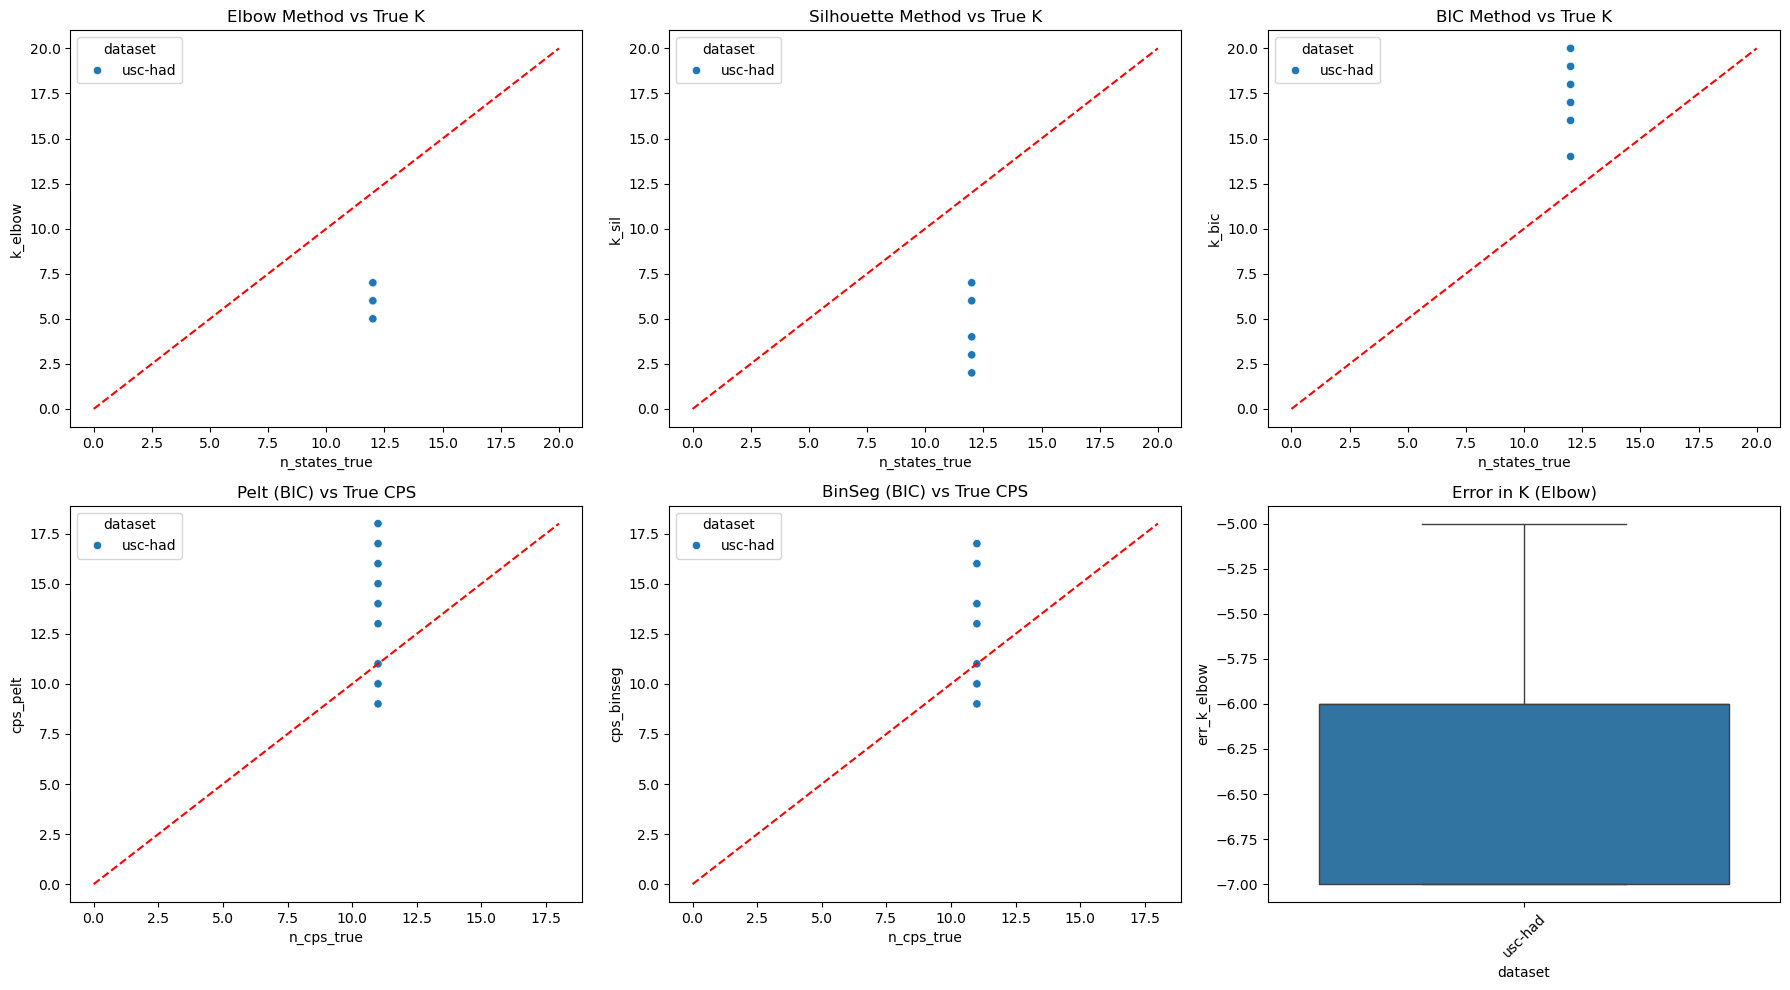

In [31]:
# Visualization
if not df_results.empty:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # n_states comparison
    sns.scatterplot(data=df_results, x='n_states_true', y='k_elbow', hue='dataset', ax=axes[0,0])
    axes[0,0].plot([0, 20], [0, 20], 'r--')
    axes[0,0].set_title("Elbow Method vs True K")
    
    sns.scatterplot(data=df_results, x='n_states_true', y='k_sil', hue='dataset', ax=axes[0,1])
    axes[0,1].plot([0, 20], [0, 20], 'r--')
    axes[0,1].set_title("Silhouette Method vs True K")
    
    sns.scatterplot(data=df_results, x='n_states_true', y='k_bic', hue='dataset', ax=axes[0,2])
    axes[0,2].plot([0, 20], [0, 20], 'r--')
    axes[0,2].set_title("BIC Method vs True K")
    
    # n_cps comparison
    max_cps = max(df_results['n_cps_true'].max(), df_results['cps_pelt'].max(), df_results['cps_binseg'].max())
    
    sns.scatterplot(data=df_results, x='n_cps_true', y='cps_pelt', hue='dataset', ax=axes[1,0])
    axes[1,0].plot([0, max_cps], [0, max_cps], 'r--')
    axes[1,0].set_title("Pelt (BIC) vs True CPS")
    
    sns.scatterplot(data=df_results, x='n_cps_true', y='cps_binseg', hue='dataset', ax=axes[1,1])
    axes[1,1].plot([0, max_cps], [0, max_cps], 'r--')
    axes[1,1].set_title("BinSeg (BIC) vs True CPS")
    
    # Error distribution
    df_results['err_k_elbow'] = df_results['k_elbow'] - df_results['n_states_true']
    sns.boxplot(data=df_results, x='dataset', y='err_k_elbow', ax=axes[1,2])
    axes[1,2].set_title("Error in K (Elbow)")
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()